<a href="https://colab.research.google.com/github/Aditib2409/EE-541-Project/blob/main/chord_classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import torch 
import torchaudio
import IPython
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzipping datasets and merging them

In [ ]:
!unzip "/content/drive/Shareddrives/EE541Project/archive.zip"   # 859 datapoints

Archive:  /content/drive/Shareddrives/EE541Project/archive.zip
  inflating: Audio_Files/Major/Major_0.wav  
  inflating: Audio_Files/Major/Major_1.wav  
  inflating: Audio_Files/Major/Major_10.wav  
  inflating: Audio_Files/Major/Major_100.wav  
  inflating: Audio_Files/Major/Major_101.wav  
  inflating: Audio_Files/Major/Major_102.wav  
  inflating: Audio_Files/Major/Major_103.wav  
  inflating: Audio_Files/Major/Major_104.wav  
  inflating: Audio_Files/Major/Major_105.wav  
  inflating: Audio_Files/Major/Major_106.wav  
  inflating: Audio_Files/Major/Major_107.wav  
  inflating: Audio_Files/Major/Major_108.wav  
  inflating: Audio_Files/Major/Major_109.wav  
  inflating: Audio_Files/Major/Major_11.wav  
  inflating: Audio_Files/Major/Major_110.wav  
  inflating: Audio_Files/Major/Major_111.wav  
  inflating: Audio_Files/Major/Major_112.wav  
  inflating: Audio_Files/Major/Major_113.wav  
  inflating: Audio_Files/Major/Major_114.wav  
  inflating: Audio_Files/Major/Major_115.wav  
  i

### Loading Dataset

In [ ]:
class loading_dataset:
    def __init__(self, path):
        self.path = path

    def harmonics(self, file_path, print=False):
        freq, X = wavfile.read(file_path)
        n = len(X)   
        X_fourier = fft(X)
        X_fourier_onesided = 2.0/n * np.abs(X_fourier[0:n // 2])
        frequencies = fftfreq(n, 1/freq)[:n//2]
        freqs_50_index = np.argmin(np.abs(frequencies - 50))
        
        ht = np.max(X_fourier_onesided)*5/100
        peaks_found, _ = find_peaks(X_fourier_onesided, distance=10, height=ht)
        peaks_found = peaks_found[peaks_found>freqs_50_index]
        harmonics_found = np.round(frequencies[peaks_found],2)

        if print:
            p = np.max(peaks_found) + 100
            plt.plot(frequencies[:p], X_fourier_onesided[:p])
            plt.plot(frequencies[peaks_found], X_fourier_onesided[peaks_found], 'o')
            plt.xlabel(f'Frequency in Hz')
            plt.ylabel(f'Harmonics')
            plt.show()
        
        return harmonics_found

    
    def create_dataframe(self):
        # to track the length of a harmonic
        length_harmonic = 0
        dataset = []

        for dir_name, _, file_name in os.walk(self.path):
            for filename in file_name:
                folder_name = os.path.basename(dir_name)
                full_filepath = os.path.join(dir_name, filename)
                harmonic_peaks = self.harmonics(full_filepath)
                min_harmonics = harmonic_peaks.min()
                max_harmonics = harmonic_peaks.max()
                num_peaks = len(harmonic_peaks)
                length_harmonic = max(num_peaks, length_harmonic)
                current_data = [folder_name, filename, min_harmonics, max_harmonics, num_peaks] 
                current_data.extend(harmonic_peaks)

                dataset.append(current_data)

        feature_cols = ["Chord_type", "File_name", "Minimum_harmonic", "Maximum_harmonic", "Num_harmonics"]
        for i in range(length_harmonic):
            feature_cols.append(f'Harmonic {i+1}')

        data_df = pd.DataFrame(dataset, columns=feature_cols)

        return data_df

In [ ]:
path = "/content/Audio_Files"
dataloader = loading_dataset(path)
data = dataloader.create_dataframe()
data_og = data

In [ ]:
def plot_kde(I, df):
    rows = len(I)
    fig, axes = plt.subplots(nrows=1, ncols=rows, figsize=(25, 3), sharex=True, sharey=True)
    axes = axes.ravel()
    for i in range(rows):
        if i <= len(I)-1:
            sns.kdeplot(ax=axes[i], data=df, x=I[i], hue="Chord_type", shade=True, palette="Set2")
    fig.suptitle(f'KDE plots of Selected Features')
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/kde_intervals.png')
    plt.show()

In [ ]:
def plot_kde_features(I, df):
    fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 35))
    axs = axes.ravel()
    for i in range(len(I)):
        if i <= len(I)-1:
            sns.kdeplot(ax=axs[i], data=df, x=I[i], hue="Chord_type", shade=True)
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/kde_features.png')
    plt.show()

## Data Visualization

In [ ]:
major_path = "/content/Audio_Files/Major/Major_1.wav"
minor_path = "/content/Audio_Files/Minor/Minor_1.wav"

In [ ]:
IPython.display.Audio(major_path, rate = 44100)

In [ ]:
IPython.display.Audio(minor_path, rate = 44100)

In [ ]:
def plot_chord_signals(path, cclass, c):
    sample_freq, audio_signal = wavfile.read(path)
    time = np.linspace(0, len(audio_signal)/sample_freq, len(audio_signal))

    # Fourier Transform
    y_freq = fftfreq(len(audio_signal), 1/sample_freq)[:len(audio_signal)//2]  # array for frequency stamps
    signal_freq = fft(audio_signal) # Signal in frequency domain
    signal_freq_onesided = 2.0/len(audio_signal) * np.abs(signal_freq[0:len(audio_signal)//2]) # taking positive terms

    # Plotting signal in time and frequency domains
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(time, audio_signal, color=c)
    axes[0].set_title(f"{cclass} Chord Wave in Time Domain")
    axes[0].set(xlabel='Time (s)')
    axes[1].plot(y_freq[:1500], signal_freq_onesided[:1500], color=c)
    axes[1].set_title(f"{cclass} Chord Wave in Frequency Domain")
    axes[1].set(xlabel='Frequency (Hz)')
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/{cclass}_signal.png')
    plt.show()

    freq, time, Sxx = spectrogram(audio_signal, sample_freq, nperseg=10000, nfft = 50000)
    plt.figure()
    plt.pcolormesh(time, freq, np.log(Sxx), cmap="CMRmap")
    plt.title(f"Spectogram of {cclass} Chord")
    plt.xlabel('Time(s)')
    plt.ylabel('Frequency(Hz)')
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/{cclass}_spectrogram.png')

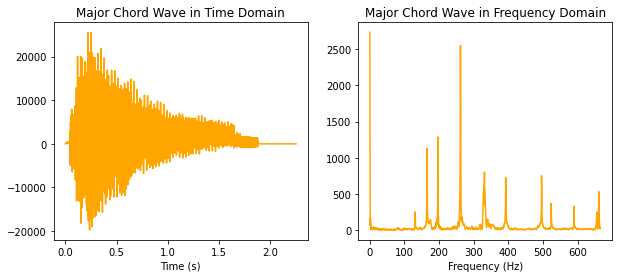

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


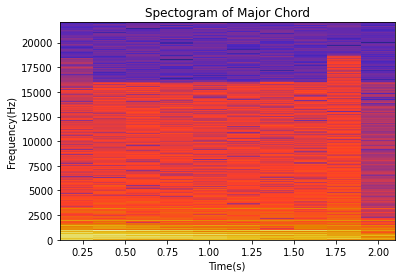

In [ ]:
plot_chord_signals(major_path, "Major", "orange")

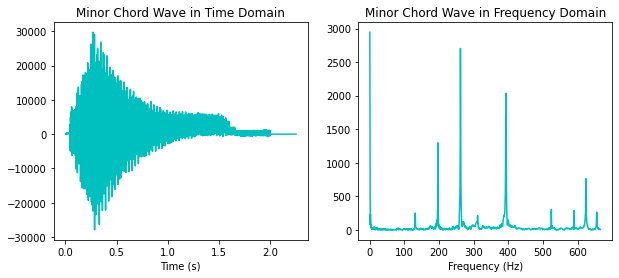

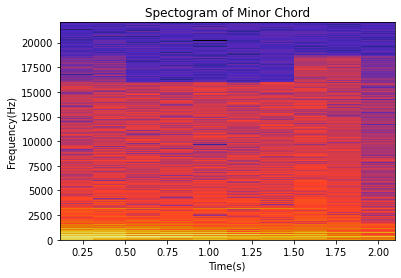

In [ ]:
plot_chord_signals(minor_path, "Minor", "c")

### Creating intervals

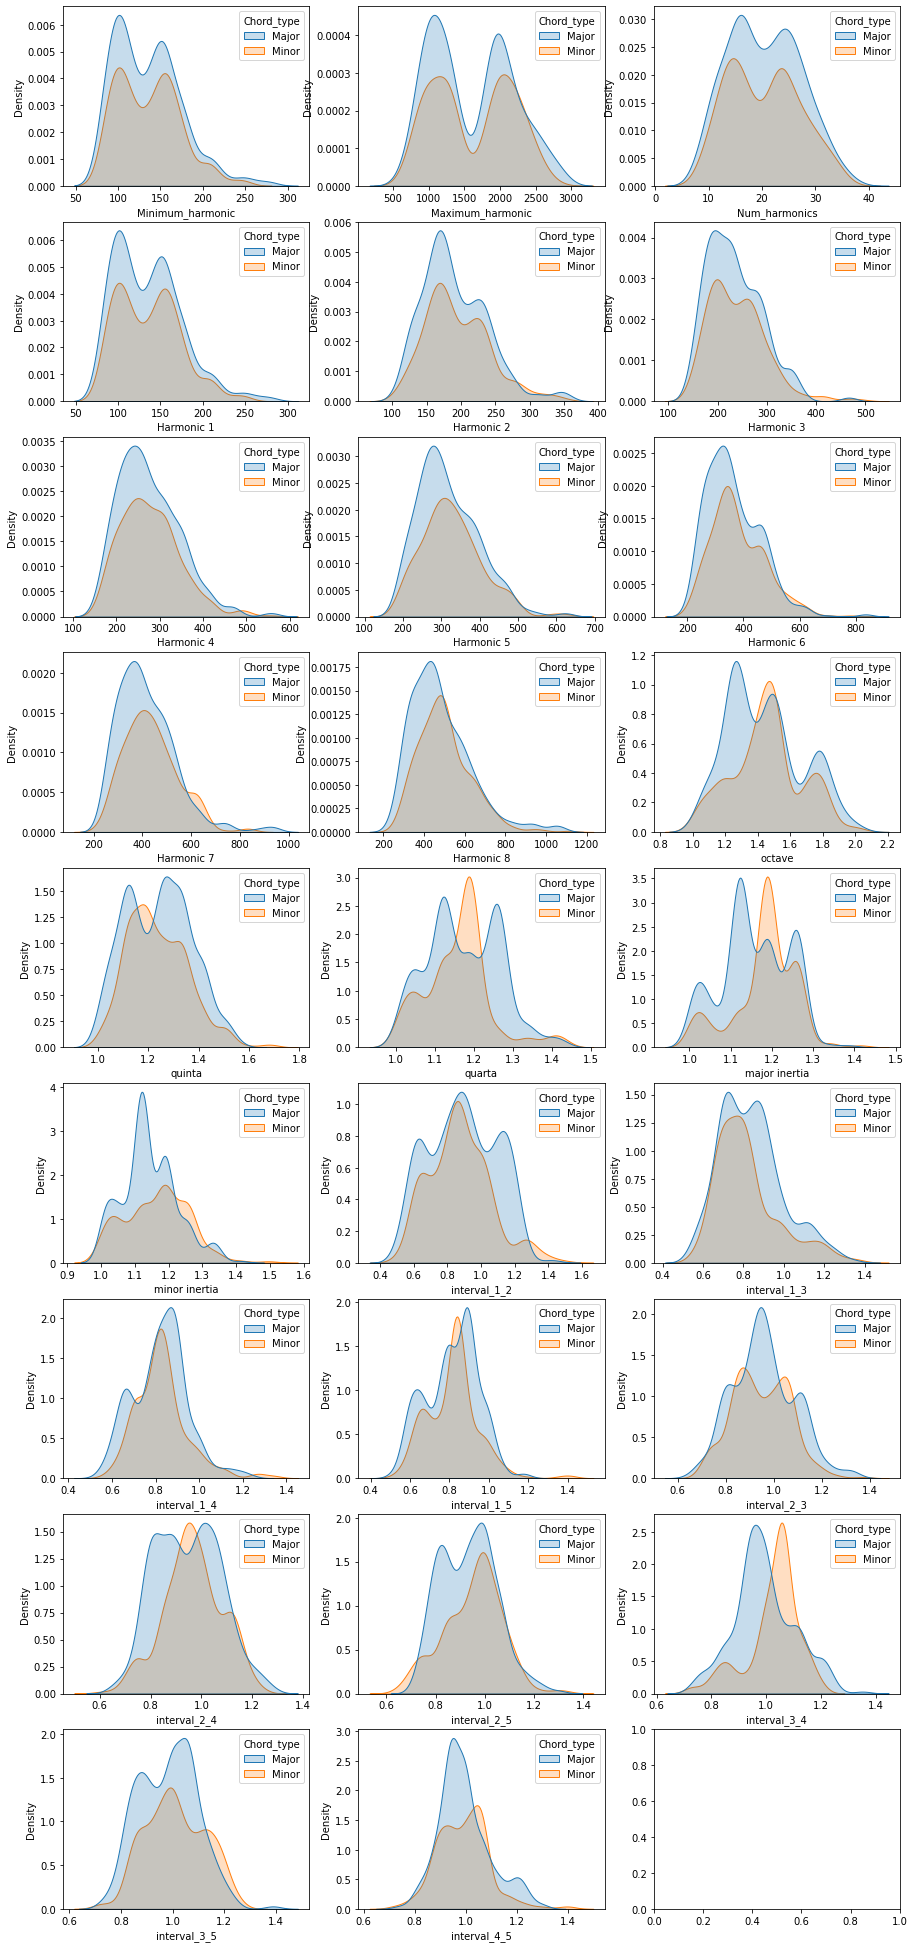

In [ ]:
intervals = ["octave", "quinta", "quarta", "major inertia", "minor inertia"]
for i in range(len(intervals)):
    data[intervals[i]] = np.divide(data[f'Harmonic {i+2}'], data[f'Harmonic {i+1}'])

# adding more intervals
for i in range(len(intervals)):
    for j in range(i+1, len(intervals)):
        data[f'interval_{i+1}_{j+1}'] = np.divide(data[intervals[j]], data[intervals[i]])

## gives list of all harmonics that have NANs. we drop those harmonics
data.isnull().sum(axis = 0)

drop_harmonics = data.columns[13:43] ## NAN values
data = data.drop(drop_harmonics, axis=1)
data = data.drop("File_name", axis=1)
new_list = list(data.columns)
plot_kde_features(new_list[1:], data)
data["Chord_type"] = data["Chord_type"].replace("Major", 0)
data["Chord_type"] = data["Chord_type"].replace("Minor", 1)
data_y = data["Chord_type"]
new_data = data.drop("Chord_type", axis=1)

## Feature Selection

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(new_data, data_y, test_size=0.15, random_state=42)

In [ ]:
test_csv = pd.concat([test_x, test_y], axis=1)
test_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Test", encoding='utf-8', index=False)

In [ ]:
def get_selected_features(df, y, df_test):
    data_x = df
    normalizer = StandardScaler()
    data_norm = normalizer.fit_transform(data_x)
    

    pca = PCA()
    data_pca = pca.fit_transform(data_norm)

    explained_variance = pca.explained_variance_ratio_
    plt.plot(explained_variance, marker='o', color='black')
    plt.title('Variances in each component')
    plt.xlabel('num of features')
    plt.ylabel('variances')

    for i in range(len(explained_variance)):
        sum_variances = explained_variance[0:i].sum()
        if sum_variances > 0.99:
            num_components = i
            break
    
    y0 = explained_variance[num_components]
    plt.plot(num_components, y0, marker='s', color='red', label=f"num_components={num_components}")
    plt.legend()
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/pca_variances.png')


    ## Recursive feature analysis
    model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
    sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=num_components, step=1)
    X_train_rfe_tree = sel_rfe_tree.fit_transform(data_norm, y)
    sel_feature_indices = sel_rfe_tree.ranking_
    # print(sel_feature_indices)

    sel_columns = data_x.columns[np.where(sel_feature_indices == 1)]

    plot_kde(sel_columns, data)

    data_transformed_train = data_x[sel_columns]
    data_transformed_test = df_test[sel_columns]

    return data_transformed_train, data_transformed_test

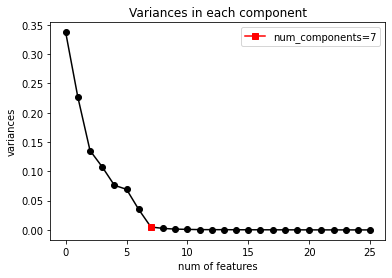

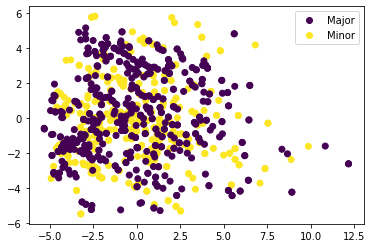

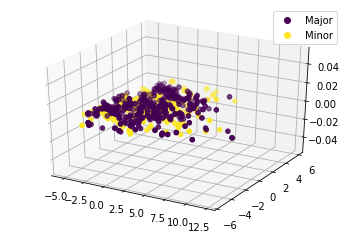

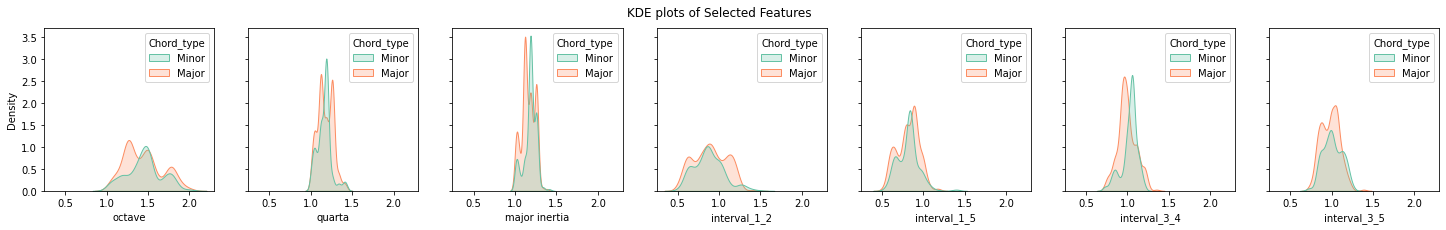

In [ ]:
train_x, test_x  = get_selected_features(train_x, train_y, test_x)

In [ ]:
df = train_x
df["Chord_type"] = train_y
sns.pairplot(df, hue="Chord_type", diag_kind="hist")

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(data_x, pd.Series(data_y, name="chord_type"), test_size=0.15, random_state=42)

In [ ]:
train_csv = pd.concat([train_x, train_y], axis=1)
test_csv = pd.concat([test_x, test_y], axis=1)
train_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Train", encoding='utf-8', index=False)
test_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Test", encoding='utf-8', index=False)

# Model Implementation


In [ ]:
# Loading train and test data (both features and labels)
traindata = pd.read_table("/content/drive/Shareddrives/EE541Project/Data/Train",
                          sep=',')
testdata = pd.read_table("/content/drive/Shareddrives/EE541Project/Data/Test",
                          sep=',')
X_train = traindata.iloc[:, :-1]
Y_train = traindata.iloc[:, -1]
X_test = testdata.iloc[:, :-1]
Y_test = testdata.iloc[:, -1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score

# Functions
def calcAccuracy(labels, preds):
    return np.mean(labels == preds)

def plotConfMat(labels, preds, filename=None):
    confmat = confusion_matrix(labels, preds)
    sns.set(rc={"figure.figsize":(8, 6)})
    p = sns.heatmap(confmat, annot=True, fmt='g')
    p.set_xlabel("Prediction", fontsize = 20)
    p.set_ylabel("Reference", fontsize = 20)
    
    if filename is not None:
        fig = p.get_figure()
        fig.savefig(filename)
        fig.clf()

accuracy = {}
f1_score = {}
precision = {}
recall = {}
roc_auc = {}
test_accuracy = {}

# Random Forest
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Naive Bayes
nb = GaussianNB()
# SVM:
svc_l = SVC(kernel='linear')     # Linear kernel
svc_p = SVC(kernel='poly')   # polynomial kernel
svc_r = SVC(kernel='rbf')        # radial kernel

models = {'RandomForest':rf, 'NaiveBayes':nb, 'SVM linear':svc_l,
          'SVM polynomial':svc_p, 'SVM radial':svc_r}

# Calculate the metrics for all ML models
# Plot confusion matrices on test data
for name, model in models.items():
    accuracy[name] = cross_val_score(model, X_train, Y_train, cv=10,
                                     scoring='accuracy')
    f1_score[name] = cross_val_score(model, X_train, Y_train, cv=10,
                                     scoring='f1')
    precision[name] = cross_val_score(model, X_train, Y_train, cv=10,
                                      scoring='precision')
    recall[name] = cross_val_score(model, X_train, Y_train, cv=10,
                                   scoring='recall')
    roc_auc[name] = cross_val_score(model, X_train, Y_train, cv=10,
                                    scoring='roc_auc')
    
    model.fit(X_train, Y_train)
    Y_hat = model.predict(X_test)
    test_accuracy[name] = calcAccuracy(Y_test, Y_hat)
    plotConfMat(Y_test, Y_hat, filename=f"/content/drive/Shareddrives/EE541Project/Figures/models/confmat_{name}.png")

In [ ]:
# Plotting evaluation metric of each model
measure = 'roc_auc'
temp_df = pd.DataFrame(roc_auc)
temp_df = pd.melt(temp_df, var_name='model', value_name=measure)
sns.set(rc={"figure.figsize":(8, 6)})
ax = sns.boxplot(x='model', y=measure, data=temp_df)
fig = ax.get_figure()
fig.savefig(f"/content/drive/Shareddrives/EE541Project/Figures/models/ML_crossval_{measure}.png")

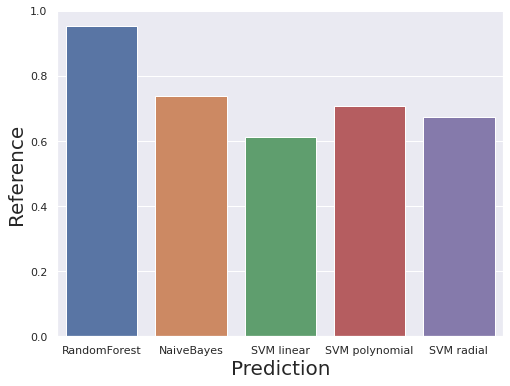

In [ ]:
# Plotting the test accuracy of all models.
sns.set(rc={"figure.figsize":(8, 6)})
p = sns.barplot(x=list(test_accuracy.keys()), y=list(test_accuracy.values()))
p.set_xlabel("Prediction", fontsize = 20)
p.set_ylabel("Reference", fontsize = 20)
fig = p.get_figure()
fig.savefig("/content/drive/Shareddrives/EE541Project/Figures/models/test_accuracy.png")

## Neural Network

In [ ]:
# Defining neural network
class ChordClassifier(nn.Module):
    
    def __init__(self, dropout_rate, dims, activation_func='relu'):
        super(ChordClassifier, self).__init__()

        # use nn.Sequential module to wrap up all the layers
        if activation_func == 'relu':
            self.net = nn.Sequential(
                nn.Linear(dims['input'], dims['hidden_1']),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(dims['hidden_1'], dims['hidden_2']),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(dims['hidden_2'], dims['output']),
                nn.Sigmoid()
            )
        elif activation_func == 'tanh':
            self.net = nn.Sequential(
                nn.Linear(dims['input'], dims['hidden_1']),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(dims['hidden_1'], dims['hidden_2']),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(dims['hidden_2'], dims['output']),
                nn.Sigmoid()
            )
        
    def forward(self, x):
        output = self.net(x)
        return output

In [ ]:
# train-validation-test split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train,
                                                      test_size=0.15)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()[..., np.newaxis]
x_valid = x_valid.to_numpy()
y_valid = y_valid.to_numpy()[..., np.newaxis]
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()[..., np.newaxis]

In [ ]:
# hyperparameters
dropout_rate = 0
activation_func = 'relu'
learning_rate = 0.01 # low learning rate
lmb = 0.001 # L2-regularization
epochs = 3000
dims = {
    'input': 7,
    'hidden_1': 5,
    'hidden_2': 3,
    'output': 1
       }

# build a binary classification model
model = ChordClassifier(dropout_rate=dropout_rate, dims=dims,
                        activation_func=activation_func)

# create optimizer and loss instances
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lmb)
loss_func = nn.BCELoss()

# start training
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
dummy_accs = []

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_valid = torch.Tensor(x_valid)
y_valid = torch.Tensor(y_valid)

for ep in range(epochs):
    model.train()
    
    
    y_hat = model(x_train)
    loss = loss_func(y_hat, y_train)
    y_hat_valid = model(x_valid)
    loss_valid = loss_func(y_hat_valid, y_valid)
    opt.zero_grad()
    loss.backward()
    train_losses.append(loss.data.numpy())
    valid_losses.append(loss_valid.data.numpy())
    
    y_hat = torch.Tensor.round(y_hat)
    y_hat_valid = torch.Tensor.round(y_hat_valid)
    train_acc = (y_hat == y_train).float()    
    train_acc = torch.Tensor.mean(train_acc)
    valid_acc = torch.Tensor.mean((y_hat_valid == y_valid).float())
    train_accs.append(train_acc.item())
    valid_accs.append(valid_acc.item())

    opt.step()

In [ ]:
# Model architecture
model

ChordClassifier(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=5, out_features=3, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=3, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

### Neural Network model accuracy on test dataset

In [ ]:
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)
y_hat_test = model(X_test)

y_hat_test = torch.Tensor.round(y_hat_test)
test_acc = torch.Tensor.mean((y_hat_test == Y_test).float()).item()
test_acc

0.8449612259864807

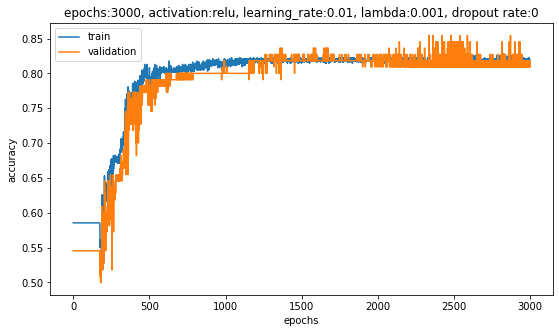

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(train_accs)
plt.plot(valid_accs)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.title(f"epochs:{epochs}, activation:{activation_func}, learning_rate:{learning_rate}, lambda:{lmb}, dropout rate:{dropout_rate}")
plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/models/nn_accuracy_{test_acc}.png', dpi=150)
plt.show()

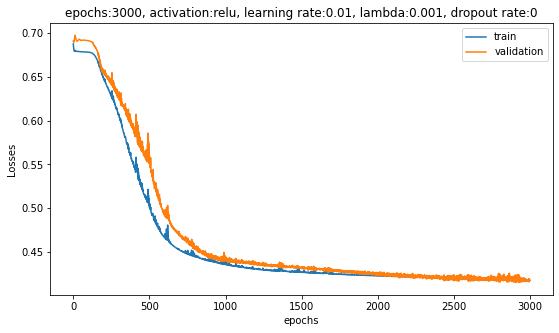

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['train', 'validation'])
plt.title(f"epochs:{epochs}, activation:{activation_func}, learning rate:{learning_rate}, lambda:{lmb}, dropout rate:{dropout_rate}")
plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/models/nn_losses_{test_acc}.png', dpi=150)
plt.show()